<a href="https://colab.research.google.com/github/sujatasahoo/Predictive-Modeling/blob/main/sujata_LS_DS_213_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from category_encoders import OneHotEncoder

In [ ]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols,parse_dates = ['SALE DATE'], 
                     index_col = 'SALE DATE', dtype = {'BOROUGH': 'object'}).sort_index()
    df.columns = df.columns.str.lower().str.replace(' ', '')
    df.dropna(inplace = True)
    df['saleprice'] = (df['saleprice'].str.replace('$','').str.replace(',','').str.replace('-','').astype(int))
    df = df[(df['buildingclasscategory'] == '01 ONE FAMILY DWELLINGS') &
               (df['saleprice']>100_000)&(df['saleprice'] < 2_000_000)]

    return df.drop(columns = 'buildingclasscategory')

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv' 

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [ ]:
df = wrangle(filepath)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,borough,neighborhood,grosssquarefeet,yearbuilt,saleprice
SALE DATE,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,1872.0,1940.0,620000


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [ ]:
# Perform your exploratory data analysis here and
# modify the wrangle function above

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [ ]:
target = 'saleprice'
y = df[target]
X = df.drop(columns = target)
X.shape

(3151, 4)

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [ ]:
X.index.max(), X.index.min()
#(Timestamp('2019-04-30 00:00:00'), Timestamp('2019-01-01 00:00:00'))
cutoff = '2019-04-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]
X_train.shape, y_train.shape

((2507, 4), (2507,))

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [ ]:
# mean sale price = y_train.mean()
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred )
print('Baseline MAE:', baseline_mae)

Baseline MAE: 214721.52773001452


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [ ]:
#Instantiate your transformer
ohe = OneHotEncoder(use_cat_names=True)
#Fit your transformer
ohe.fit(X_train)
#Transfor
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)
XT_train.shape

(2507, 183)

**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [ ]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)


LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [ ]:
model_r = Ridge(alpha = 1.0)
model_r.fit(XT_train,y_train)


Ridge()

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [ ]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 127203.37255684084
Linear Test MAE: 5690532939131.901


**Task 10:** Check the training and test metrics for `model_r`.

In [ ]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 126035.03017055118
Ridge Test MAE: 138773.29519519108


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [ ]:
# Caculate R^2 score
training_r2 = model_r.score(XT_train, y_train)
test_r2 = model_r.score(XT_test, y_test)
print('R_Training R^2:', training_r2)
print('R_Test R^2:', test_r2)

R_Training R^2: 0.6184461662522489
R_Test R^2: 0.4879994292970723


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

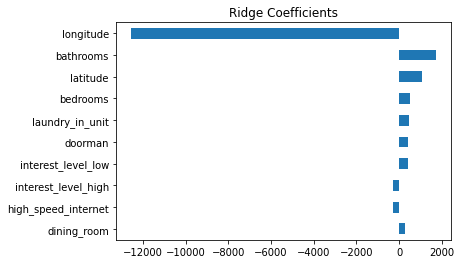

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

In [ ]:
coefficiecnts = model_r.coef_
features = ohe.get_feature_names()

feat_imp = pd.Series(coefficiecnts, index = features ).sort_values(key = abs)
feat_imp

neighborhood_CITY ISLAND                     93.425551
grosssquarefeet                             169.992599
neighborhood_ROSEBANK                       440.642263
yearbuilt                                   483.124767
neighborhood_CASTLETON CORNERS              666.017606
                                             ...      
neighborhood_FLATBUSH-LEFFERTS GARDEN    393296.925052
neighborhood_HAMMELS                    -396710.028543
neighborhood_FOREST HILLS                415954.336046
neighborhood_PARK SLOPE SOUTH            478893.276963
neighborhood_WINDSOR TERRACE             518583.294337
Length: 183, dtype: float64

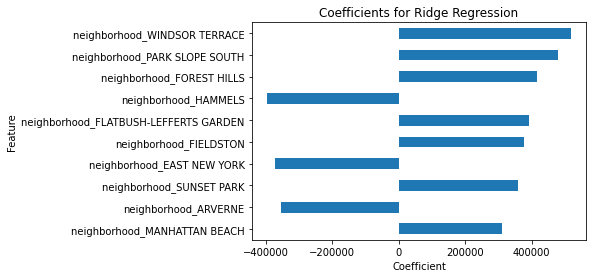

In [ ]:
feat_imp.tail(10).plot(kind= 'barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');
